## Transfer Learning for Image Classification

In this notebook, we will use transfer learning on an image classification problem. Our dataset is made of two classes of images: 
* sw (software)
* vg (video games)

## 1. Installing libraries and reading the dataset

In [1]:
# Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved.
# SPDX-License-Identifier: CC-BY-SA-4.0

# Installing the gluoncv library
! pip install -q gluoncv

You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


Importing libraries below

In [2]:
import os, time
import mxnet as mx
from mxnet import nd, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms
from gluoncv.model_zoo import get_model

Let's clean our workspace and read our dataset:

In [3]:
! rm -rf images
! unzip -q ../../DATA/CV/EMBK-NLP-GLUONCV.zip

Looking at our training and validation folders below. We have 500 training images and 100 validation images from each class. In total 1000 images for training and 200 for validation. We have this folder structure:

images <br />
&emsp; train <br />
&emsp; &emsp; sw <br />
&emsp; &emsp; vg <br />
&emsp; val <br />
&emsp; &emsp; sw <br />
&emsp; &emsp; vg <br />

In [4]:
! ls images

train  val


Let's see one sample image.

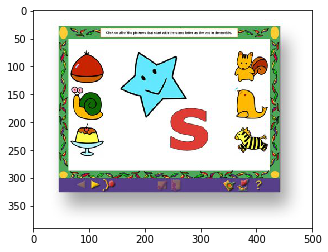

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

im = mpimg.imread('images/train/sw/23.jpg')

plt.imshow(im)
plt.show()

## 2. Loading the Data and Training

In this section, we will see how to read images and use a pre-trained Alexnet model to create an image classifier.

We define our parameters below.

In [6]:
classes = 2
epochs = 5
lr = 0.001
batch_size = 32
ctx = mx.cpu() # use mx.gpu() for gpu

### Preparing the dataset
Our model reads images from two folders: "train" and "val". We will use ImageFolderDataset() from Gluon vision package to create our training and validation datasets.

In [7]:
path = 'images'
train_path = os.path.join(path, 'train')
val_path = os.path.join(path, 'val')

train_dataset = gluon.data.vision.ImageFolderDataset(train_path)
val_dataset = gluon.data.vision.ImageFolderDataset(val_path)

Let' see the first 10 items below.

In [8]:
print("Training set size:", len(train_dataset.items), \
      "Validation set size:", len(val_dataset.items))

Training set size: 1000 Validation set size: 200


Before we feed the images to our network, we need to make sure that they are resized to the same size (224, 224) and normalized.

In [9]:
transform_data = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize()
])

Next, we create our data loaders for training and validation.

In [10]:
train_data = gluon.data.DataLoader(
    train_dataset.transform_first(transform_data),
    batch_size=batch_size, shuffle=True)

val_data = gluon.data.DataLoader(
    val_dataset.transform_first(transform_data),
    batch_size=batch_size, shuffle=False)

### Fine-tuning Alexnet

We will fine-tune a pre-trained Alexnet model. The following code takes this pre-trained network and changes the output shape of it. When we start training this network, it starts with the pre-trained weights.

In [11]:
model_name = 'alexnet'
finetune_net = get_model(model_name, pretrained=True)
with finetune_net.name_scope():
    finetune_net.output = nn.Dense(classes)
    
finetune_net.output.initialize(init.Xavier(), ctx = ctx)

### Loss and Trainer

Let's define our training algorithm and loss function. We will use __Stochastic Gradient Descent__ and __SoftmaxCrossEntropyLoss__. 

In [12]:
trainer = gluon.Trainer(finetune_net.collect_params(),
                        'sgd',
                        {'learning_rate': lr})

softmax_loss = gluon.loss.SoftmaxCrossEntropyLoss()

### Traning and validation
Let's start the training below. We will calculate the loss for training and validation sets and print them at the end of each epoch. With regular CPU instances, training will take some time. We also print the time it takes for training and validation at each epoch.

In [14]:
import time
for epoch in range(epochs):
    start = time.time()
    train_loss = 0
    # Training loop, train the network
    for idx, (data, target) in enumerate(train_data):
        data = data.as_in_context(ctx)
        target = target.as_in_context(ctx)
        
        with autograd.record():
            output = finetune_net(data)
            L = softmax_loss(output, target)
            train_loss += nd.sum(L).asscalar()
            L.backward()
        trainer.step(data.shape[0])
    
    val_loss = 0
    for idx, (v_data, v_target) in enumerate(val_data):
        # Calculate validation loss
        val_predictions = finetune_net(v_data.as_in_context(ctx))
        val_batch_loss = softmax_loss(val_predictions, v_target.as_in_context(ctx))
        val_loss += nd.sum(val_batch_loss).asscalar()
        
    # Let's take the average losses
    train_loss = train_loss / len(train_dataset.items)
    val_loss = val_loss / len(val_dataset.items)
    
    end = time.time()
    print("Epoch %s. Train_loss %f Val_loss %f Seconds %f" % \
          (epoch, train_loss, val_loss, end-start))

Epoch 0. Train_loss 0.635555 Val_loss 0.414898 Seconds 118.367706
Epoch 1. Train_loss 0.581308 Val_loss 0.404406 Seconds 118.726811
Epoch 2. Train_loss 0.554125 Val_loss 0.398550 Seconds 116.838166
Epoch 3. Train_loss 0.499824 Val_loss 0.400709 Seconds 118.499750
Epoch 4. Train_loss 0.468982 Val_loss 0.388534 Seconds 119.056049
